In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


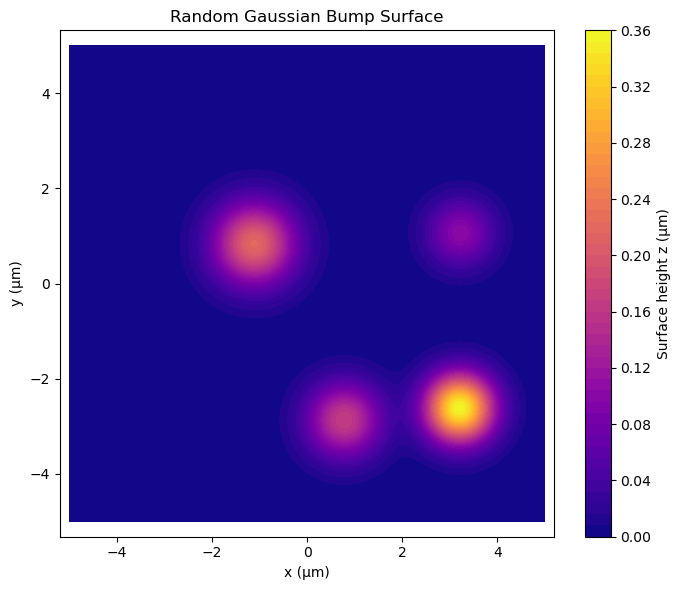

In [2]:
# Re-run and add CSV export of bump parameters

# Grid for surface
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

np.random.seed(4)  # for reproducibility

# Generate random bump parameters
num_bumps = np.random.randint(2, 5)
bump_data = []

for i in range(num_bumps):
    x0 = np.random.uniform(-4, 4)
    y0 = np.random.uniform(-4, 4)
    height = np.random.uniform(0.1, 0.4)
    sigma = np.random.uniform(0.2, 0.7)

    bump = height * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
    Z += bump

    bump_data.append({
        "bump_id": i,
        "x0": x0,
        "y0": y0,
        "height": height,
        "sigma": sigma
    })

# Optional base level (like a flat substrate)
Z -= 0

# Export bump parameters to CSV
bump_df = pd.DataFrame(bump_data)
csv_path = "/mnt/c/Users/tripl/OneDrive - Danmarks Tekniske Universitet/Speciale/bioscat3d/MeepTests/dataDump.csv"  # Provide download path
bump_df.to_csv(csv_path, index=False)

# Plot the surface
plt.figure(figsize=(7, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='plasma')
plt.colorbar(contour, label="Surface height z (μm)")
plt.title("Random Gaussian Bump Surface")
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [3]:
# Simulation parameters
resolution = 10 # pixels/um
pml_thickness = 2
dim = 20
cell_x = dim
cell_y = dim
cell_z = dim

sphere_radius = 1.0
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

# Plane wave incidence defined by polar and azimuthal angles (in degrees)
theta_deg = 20  # Polar angle from +Z
phi_deg = 0    # Azimuthal angle in x–y plane

# Convert to radians
theta = np.radians(theta_deg)
phi = np.radians(phi_deg)

# Build normalized k-vector
k_unit = mp.Vector3(
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    -np.cos(theta)  # negative for downward propagation
)

# Scale for Meep's eig_kpoint (|k| = frequency in Meep units)
eig_kpoint = k_unit.scale(frequency)



In [4]:
bump_df = pd.read_csv("dataDump.csv")
bump_data = bump_df.to_dict(orient='records')

# Define your substrate material
substrate_material = mp.Medium(epsilon=2.56)

# Material function: sum all Gaussian bumps
def bump_surface_material(p):
    z_surface = 0.0
    for bump in bump_data:
        x0 = bump["x0"]
        y0 = bump["y0"]
        h = bump["height"]
        sigma = bump["sigma"]
        
        r2 = (p.x - x0)**2 + (p.y - y0)**2
        z_surface += h * np.exp(-r2 / (2 * sigma**2))

    return substrate_material if p.z < z_surface else mp.air

# Source: downward plane wave at angles
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=mp.Vector3(cell_x, cell_y, 0),
        direction=mp.Z,  # still Z, but mode defines propagation
        eig_kpoint=eig_kpoint,
        eig_band=1,
        eig_match_freq=True
    )
]


# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    sources=sources, # you can still add discrete objects
    default_material=bump_surface_material
)


# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}

# Run the simulation
sim.run(until=60)


-----------
Initializing structure...
time for choose_chunkdivision = 0.00101995 s
Working in 3D dimensions.
Computational cell is 20 x 20 x 20 with resolution 10


subpixel-averaging is 43.8704% done, 5.12171 s remaining
subpixel-averaging is 91.157% done, 0.388721 s remaining
subpixel-averaging is 43.5108% done, 5.21398 s remaining
subpixel-averaging is 87.0217% done, 0.59856 s remaining
subpixel-averaging is 49.4441% done, 4.09824 s remaining
subpixel-averaging is 97.0903% done, 0.120176 s remaining
subpixel-averaging is 50.1633% done, 3.98679 s remaining
subpixel-averaging is 48.7249% done, 4.21654 s remaining
subpixel-averaging is 98.1691% done, 0.0747591 s remaining
subpixel-averaging is 50.7026% done, 3.90276 s remaining
subpixel-averaging is 6.39352% done, 58.5951 s remaining
subpixel-averaging is 12.588% done, 27.8253 s remaining
subpixel-averaging is 18.8323% done, 17.2574 s remaining
subpixel-averaging is 26.8927% done, 10.9061 s remaining
subpixel-averaging is 33.4355% done, 7.9729 s remaining
subpixel-averaging is 40.2768% done, 5.95193 s remaining
subpixel-averaging is 47.0435% done, 4.517 s remaining
subpixel-averaging is 52.7156% d

In [5]:
def plot_field_slice_with_bumps(abs_E, axis='y', index=None, projection=False,
                                 extent=None, cmap_field='inferno',
                                 Z=None, contour_levels=10, cmap_contour='plasma',
                                 alpha_contour=0.5, title=None):
    """
    Plot a 2D slice or projection of a 3D field with optional bump surface contours.

    Parameters:
    - abs_E: 3D numpy array (shape [x, y, z])
    - axis: 'x', 'y', or 'z' — axis to slice or project along
    - index: slice index if not projecting (defaults to center)
    - projection: if True, take max projection along the axis
    - extent: (xmin, xmax, ymin, ymax) for plot axes
    - cmap_field: colormap for |E|
    - Z: optional 2D bump surface (shape [x, y]); will be transposed and flipped to match
    - contour_levels: number of contour levels
    - cmap_contour: colormap for contours
    - alpha_contour: transparency of contours
    - title: plot title
    """
    axis_dict = {'x': 0, 'y': 1, 'z': 2}
    ax = axis_dict[axis]

    # Default extent if none provided
    extent = extent or [-1, 1, -1, 1]

    if projection:
        slice_2d = np.max(abs_E, axis=ax)
        label = f'Max projection along {axis.upper()}'
        # Transpose for correct display orientation (Y vertical, X horizontal)
        if axis == 'z':
            slice_2d = slice_2d.T
    else:
        if index is None:
            index = abs_E.shape[ax] // 2
        slicer = [slice(None)] * 3
        slicer[ax] = index
        slice_2d = abs_E[tuple(slicer)]
        label = f'Slice at {axis.upper()} = {index}'
        # Transpose if slicing along x or y for proper display
        if axis in ['x', 'y']:
            slice_2d = slice_2d.T

    # Plot the field slice
    plt.figure(dpi=100, figsize=(7, 6))
    plt.imshow(slice_2d, cmap=cmap_field, origin='lower', extent=extent)
    plt.colorbar(label='|E|')

    # Optional: overlay contour from bump surface
    if Z is not None:
        Z_plot = Z  # Flip and transpose to match imshow orientation
        plt.contour(Z_plot, levels=contour_levels, extent=extent,
                    cmap=cmap_contour, alpha=alpha_contour)

    # Axis labels
    if axis == 'x':
        plt.xlabel("y (µm)")
        plt.ylabel("z (µm)")
    elif axis == 'y':
        plt.xlabel("x (µm)")
        plt.ylabel("z (µm)")
    elif axis == 'z':
        plt.xlabel("x (µm)")
        plt.ylabel("y (µm)")

    plt.title(title or label)
    plt.tight_layout()
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_field_with_bumps(abs_E, Z, extent, axis='z', cmap_field='inferno', cmap_contour='plasma', alpha_contour=0.5, title=None):
    """
    Overlay a bump surface Z(x, y) as contours on top of a 2D projection of |E| from abs_E.

    Parameters:
    - abs_E: 3D numpy array (shape: x, y, z)
    - Z: 2D bump surface (shape: X, Y)
    - extent: (xmin, xmax, ymin, ymax) — must match both field and surface
    - axis: projection axis ('x', 'y', 'z')
    - cmap_field: colormap for |E| background
    - cmap_contour: colormap for bump contours
    - alpha_contour: opacity of contours
    - title: optional plot title
    """
    axis_dict = {'x': 0, 'y': 1, 'z': 2}
    ax = axis_dict[axis]

    # Project the field
    field_proj = np.max(abs_E, axis=ax)

    # For z-projection, transpose to get (y, x) orientation for imshow
    if axis == 'z':
        field_proj = field_proj.T

    # Transpose Z to align with imshow
    Z_plot = Z # transpose


    # Plot
    plt.figure(figsize=(7, 6), dpi=100)
    plt.imshow(field_proj, cmap=cmap_field, origin='lower', extent=extent)
    plt.contour(Z_plot, levels=10, extent=extent, cmap=cmap_contour, alpha=alpha_contour)
    plt.colorbar(label='|E|')
    plt.xlabel('x (μm)')
    plt.ylabel('y (μm)')
    plt.title(title or f'Max |E| with Bump Contours (projection along {axis})')
    plt.tight_layout()
    plt.show()


In [7]:
# Print flux values
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# Assume abs_E is shape (160, 12, 160) → (x, y, z)

# Full 3D array extraction
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ez)

# Total magnitude
abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)


# === Print total flux through each monitor ===
for name, monitor in flux_monitors.items():
    flux_val = mp.get_fluxes(monitor)[0]
    print(f"Flux through {name}: {flux_val:.6f}")

# === Full 3D Electric Field Extraction ===
# Assume simulation has finished and fields are stored in the simulation domain

# Extract Ex, Ey, Ez components from the full cell
ex = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ex)
ey = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ey)
ez = sim.get_array(center=mp.Vector3(), size=mp.Vector3(cell_x, cell_y, cell_z), component=mp.Ez)

# Compute total electric field magnitude |E| = sqrt(Ex² + Ey² + Ez²)
abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

# Optional: save field for later reuse
np.save("abs_E.npy", abs_E)

Flux through top: 16.223786
Flux through bottom: -198.620158
Flux through left: 2.155470
Flux through right: -5.790808
Flux through front: 4.718810
Flux through back: -4.386531
Flux through top: 16.223786
Flux through bottom: -198.620158
Flux through left: 2.155470
Flux through right: -5.790808
Flux through front: 4.718810
Flux through back: -4.386531


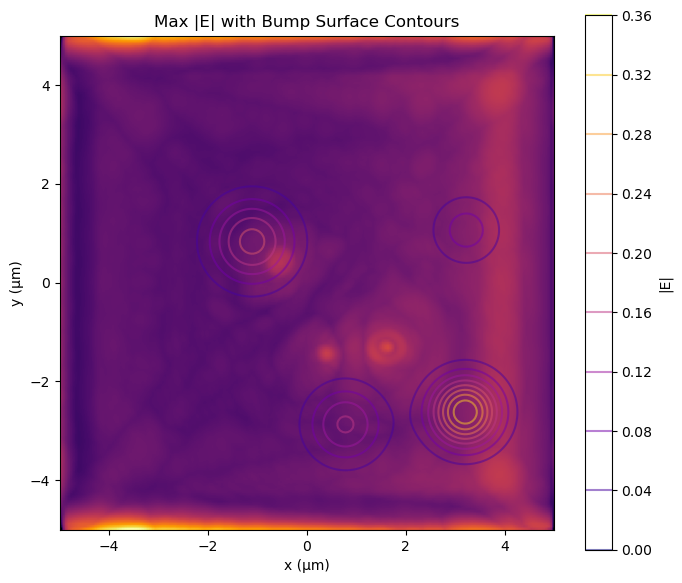

In [8]:
extent = [-5, 5, -5, 5]
plot_field_with_bumps(
    abs_E=abs_E,
    Z=Z,
    extent=extent,
    axis='z',
    title="Max |E| with Bump Surface Contours"
)


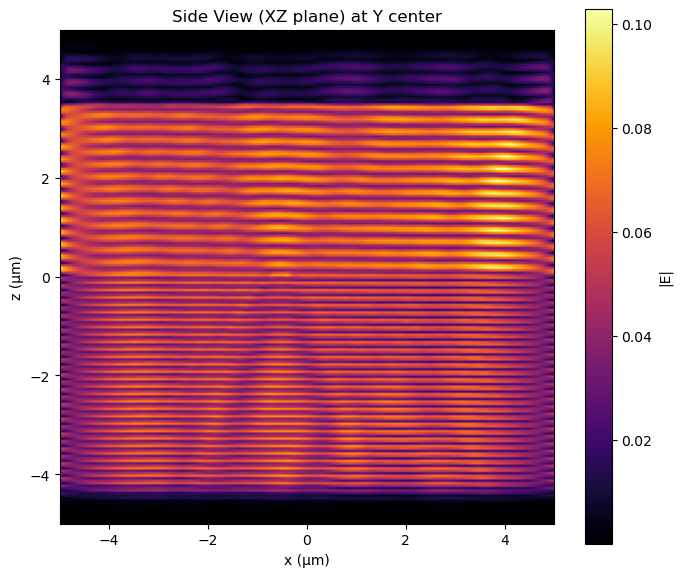

In [9]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='y',
    index=abs_E.shape[1] // 2,
    extent=extent,
    title="Side View (XZ plane) at Y center"
)



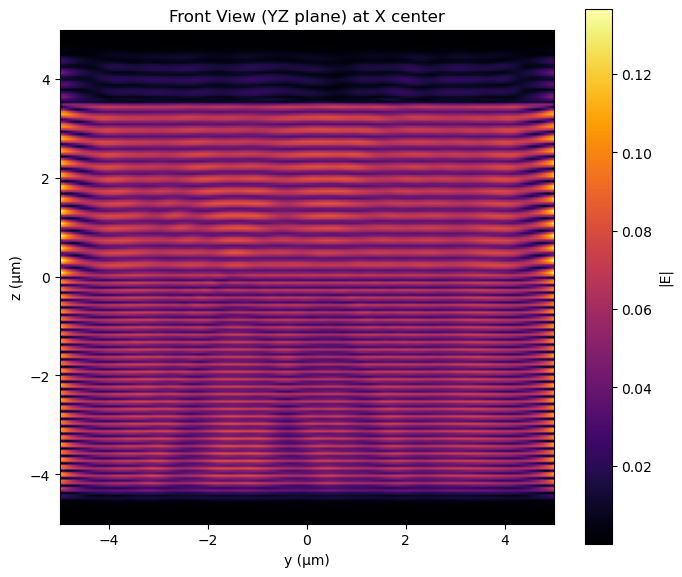

In [10]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='x',
    index=abs_E.shape[0] // 2,
    extent=extent,
    title="Front View (YZ plane) at X center"
)


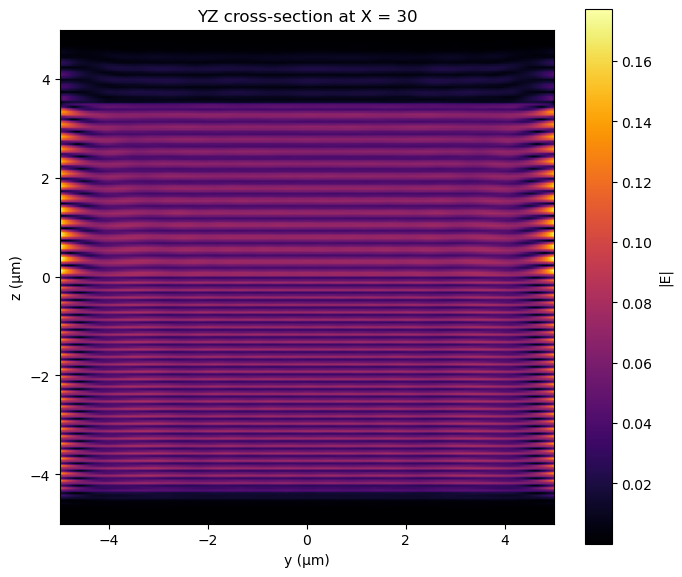

In [11]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='x',
    index=30,
    extent=extent,
    title="YZ cross-section at X = 30"
)


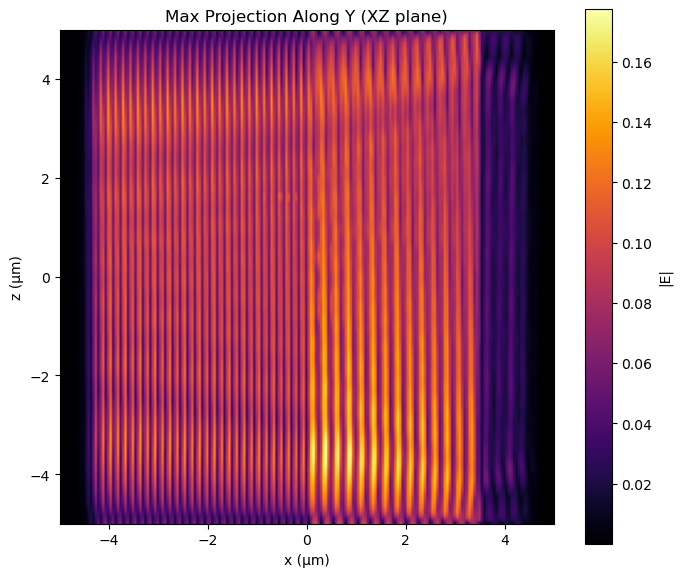

In [12]:
plot_field_slice_with_bumps(
    abs_E=abs_E,
    axis='y',
    projection=True,
    extent=extent,
    title="Max Projection Along Y (XZ plane)"
)
